In [1]:
import sys
sys.path.insert(0, "/home/jogi/git/repository/meta_learner")
if "/home/jogi/.local/lib/python2.7/site-packages" in sys.path:
    sys.path.remove("/home/jogi/.local/lib/python2.7/site-packages")

import matplotlib
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

from datetime import datetime
from pytz import timezone
import itertools
import copy

import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

import numpy as np
import dill
import os
from collections import OrderedDict


from utils.experiment import Experiment
from utils.common import get_model, create_def_argparser, create_logger, softmax
from utils.common import compute_total_steps, get_evaluation_step_loss
from utils.plots import loss_plot, param_error_plot, plot_qt_probs, plot_dist_optimization_steps
from utils.plots import plot_actsb_qts, plot_image_map_data, plot_image_map_losses
from utils.plots import plot_loss_over_tsteps, plot_halting_step_stats_with_loss, plot_loss_versus_halting_step
from utils.plots import plot_marginal_qz
from utils.probs import TimeStepsDist, ConditionalTimeStepDist
from utils.config import config
from val_optimizer import validate_optimizer
from utils.regression import RegressionFunction, L2LQuadratic, RegressionWithStudentT
from utils.helper import tensor_and, tensor_any
from utils.batch_handler import ACTBatchHandler
from utils.epoch import Epoch, halting_step_stats
from models.rnn_optimizer import MetaLearner, AdaptiveMetaLearnerV1, AdaptiveMetaLearnerV2
from models.sb_act_optimizer import StickBreakingACTBaseModel

from utils.regression import RegressionFunction, L2LQuadratic, neg_log_likelihood_loss, RosenBrock
from utils.regression import RegressionWithStudentT

%load_ext autoreload
%autoreload 2

In [2]:
expers_to_load = [ # BASELINE on Regression T
                  (False, "run_20171025_17_38_23_metaV1_40ep_5ops_lr4e05"), # 2,000,000 H=5
                  (False, "run_20171025_17_33_07_metaV1_20ep_10ops_lr4e05"), # 2,0000000 H=10
                  (False, "run_20171025_17_27_44_metaV1_10ep_20ops_lr4e05"), # 2,000,000 opt steps H=20
                  (False, "run_20170930_15_17_50_metaV1_45ep_25ops_lr4e05"), # 25
                  (False, "run_20170930_12_21_10_metaV1_50ep_50ops_lr4e05"), # 50 steps
                  (False, "run_20171001_12_01_01_metaV1_30ep_100ops_lr4e05"), # 100 steps
                  # Best M-ACT on Regression T
                  (False, "run_20171002_23_12_29_meta_actV1_45ep_tau0.0018_lr5e05"),  # best used
                  # M-PACT V1 model regression T
                  (True, "run_20171003_21_29_12_act_sbV3.2_50ep_nu0.5kls1.0_lr5e05"),   # best used
                  (True, "run_20171004_10_30_10_act_sbV3.2_45ep_nu0.7kls1.0_lr5e05"),
                  (True, "run_20171003_22_05_48_act_sbV3.2_50ep_nu0.95kls1.0_lr5e05")
                  ]



In [3]:
## IMPORTANT ---- NUMBER OF STEPS FOR TEST EVALUATION
MAX_EVAL_STEPS = 35

without_models = False

path_ext = None
experiments = []
models = []
new_experiments = []
explogger = None
m = 0
if 'logger' in vars() or 'logger' in globals():
    pass
else:
    logger = create_logger(exper=None, file_handler=True, output_dir="/home/jogi/git/repository/meta_learner/logs")

for e, exp_path in enumerate(expers_to_load):
    if exp_path[0]:
        
        if path_ext is not None:
            exp_file_path = os.path.join(path_ext, exp_path[1])
        else:
            exp_file_path = exp_path[1]
            
        exp = Experiment.load(exp_file_path, do_log=True, meta_logger=logger)
            
        if "act" in exp.args.model:
            print("{} Loading model {} (q-prob {:.2f}) / {}".format(m, exp.args.model, 
                                                                    exp.config.ptT_shape_param,
                                                                    exp.args.log_dir))
        else:
            print("{} Loading model {} / {}".format(m, exp.args.model, exp.args.log_dir))
        
        experiments.append(exp)
        m += 1
        if not without_models:
            num_inputs = 1
            if exp.args.problem == 'mlp':
                num_inputs = 3
            models.append(get_model(exp, num_inputs, retrain=True))
        new_experiments.append(Experiment(exp.args, exp.config, set_seed=True))
        new_experiments[-1].batch_handler_class = experiments[-1].batch_handler_class
        new_experiments[-1].output_dir = experiments[-1].output_dir
        new_experiments[-1].reset_val_stats()
        new_experiments[-1].meta_logger = logger
        new_experiments[-1].validation_handler_class = experiments[-1].validation_handler_class
        new_experiments[-1].training_horizon = experiments[-1].config.T
        new_experiments[-1].avg_num_opt_steps = experiments[-1].avg_num_opt_steps

INFO - created local logger for experiment with model act_sbV3.2_regression_T_nu0.5
INFO - INFO - loaded existing model from file logs/run_20171003_21_29_12_act_sbV3.2_50ep_nu0.5kls1.0_lr5e05/act_sbV3.2_regression_T_nu0.5.pkl
INFO - Note: StickBreakingACTBaseModel is running on GPU
INFO - ['linear_in.weight', 'linear_in.bias', 'lstms.0.fc_i2h.weight', 'lstms.0.fc_i2h.bias', 'lstms.0.fc_h2h.weight', 'lstms.0.fc_h2h.bias', 'lstms.1.fc_i2h.weight', 'lstms.1.fc_i2h.bias', 'lstms.1.fc_h2h.weight', 'lstms.1.fc_h2h.bias', 'theta_linear_out.weight', 'rho_linear_out.weight', 'rho_linear_out.bias']
INFO - created local logger for experiment with model act_sbV3.2_regression_T_nu0.7
INFO - INFO - loaded existing model from file logs/run_20171004_10_30_10_act_sbV3.2_45ep_nu0.7kls1.0_lr5e05/act_sbV3.2_regression_T_nu0.7.pkl
INFO - Note: StickBreakingACTBaseModel is running on GPU
INFO - ['linear_in.weight', 'linear_in.bias', 'lstms.0.fc_i2h.weight', 'lstms.0.fc_i2h.bias', 'lstms.0.fc_h2h.weight', 'l

0 Loading model act_sbV3.2_regression_T_nu0.5 (q-prob 0.50) / run_20171003_21_29_12_act_sbV3.2_50ep_nu0.5kls1.0_lr5e05
1 Loading model act_sbV3.2_regression_T_nu0.7 (q-prob 0.70) / run_20171004_10_30_10_act_sbV3.2_45ep_nu0.7kls1.0_lr5e05
2 Loading model act_sbV3.2_regression_T_nu0.95 (q-prob 0.95) / run_20171003_22_05_48_act_sbV3.2_50ep_nu0.95kls1.0_lr5e05


In [4]:
# del new_experiments
new_experiments = []
unrolled_steps=200
num_of_funcs = 10000

if 'logger' in vars() or 'logger' in globals():
    pass
else:
    logger = create_logger(exper=None, file_handler=True, output_dir="/home/jogi/git/repository/meta_learner/logs")

for exper in expers_to_load:
    if exper[0]:
        
        path_to_exp = exper[1] + "/" + "exp_eval_stats_" + str(num_of_funcs) + "_" + str(unrolled_steps) +"steps.dll"
        print("Loading experiment {} / path {}".format(exper[1], path_to_exp))
        new_experiments.append(Experiment.load(path_to_exp=path_to_exp,
                                               full_path=True))
        if new_experiments[-1].meta_logger is None:
            new_experiments[-1].meta_logger = logger
print("Ready")

Loading experiment run_20171003_21_29_12_act_sbV3.2_50ep_nu0.5kls1.0_lr5e05 / path run_20171003_21_29_12_act_sbV3.2_50ep_nu0.5kls1.0_lr5e05/exp_eval_stats_10000_200steps.dll
Loading experiment run_20171004_10_30_10_act_sbV3.2_45ep_nu0.7kls1.0_lr5e05 / path run_20171004_10_30_10_act_sbV3.2_45ep_nu0.7kls1.0_lr5e05/exp_eval_stats_10000_200steps.dll
Loading experiment run_20171003_22_05_48_act_sbV3.2_50ep_nu0.95kls1.0_lr5e05 / path run_20171003_22_05_48_act_sbV3.2_50ep_nu0.95kls1.0_lr5e05/exp_eval_stats_10000_200steps.dll
Ready


In [4]:
with open("data/test_regression_T_10000_10_1.0_10.dll", 'rb') as f:
     test_funcs = dill.load(f)
print("Ready")

Ready


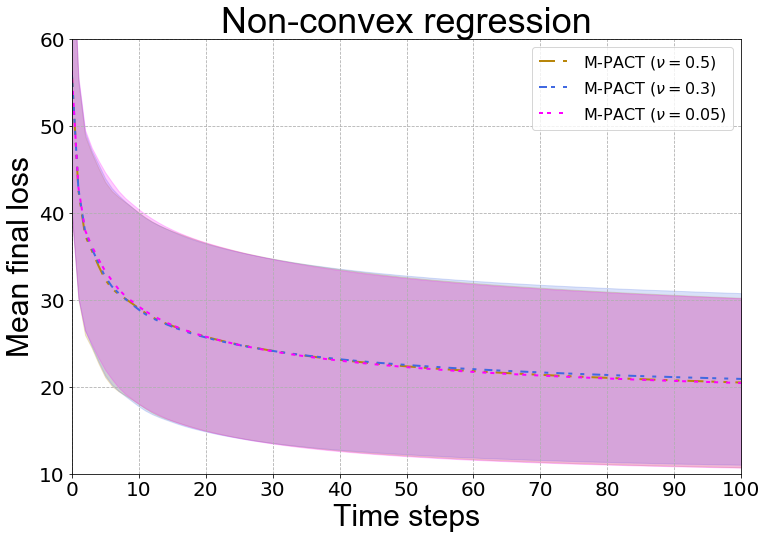

In [13]:
#new_exp_select = [new_experiments[0], new_experiments[1], new_experiments[2], new_experiments[4],
#                 new_experiments[6]] 
#, new_experiments[4]] 

part = 1
if part == 1:
    min_step = 0
    max_step = 100
    y_lim = [10,60 ]
    log_scale  = False
elif part == 2:
    min_step = 100
    max_step = 200
    log_scale = True
    y_lim=[8.5, 35]
else:
    log_scale = True
    min_step = 0
    max_step = 100
    y_lim=[8.5, 56]

best_val_runs, lowest_value = plot_loss_over_tsteps(new_experiments, do_show=True, 
                                              do_save=False, 
                                              plot_best=False,   #  10regT_MPACT_    10regT_ALL_
                                              fig_name="10regT_MPACT_" + str(min_step) + "_" + str(max_step),
                                              loss_type="loss",
                                              min_step=min_step,
                                              max_step=max_step,
                                              sort_exper="Non-convex regression",
                                              log_scale=log_scale,
                                              y_lim=y_lim,
                                              with_stddev=True,
                                              runID=None)

In [ ]:
# eval_new_val_expers = [new_experiments[0], new_experiments[3]] #, new_experiments[5]]

best_val_runs, lowest_value = plot_val_result(new_experiments, 
                                              do_show=True, 
                                              do_save=True, 
                                              plot_best=False,
                                              loss_type="loss",
                                              fig_name="expv5_val_results_1000_loss_10ops")

In [ ]:
# eval_expers = new_exp_only = [experiments[0], experiments[1], experiments[2]]
plot_parm_loss_steps(experiments, num_of_plots=4, do_show=True, 
                     do_save=False, loss_type="loss", log_scale=False, max_step=20,
                    fig_name="metaV2_val_loss_during_training")

In [50]:
exp_idx = 2
model = models[exp_idx]

max_steps = 200
# new_experiments[exp_idx].model_path

new_experiments[exp_idx].epoch = 400
new_experiments[exp_idx].config.max_val_opt_steps = max_steps
new_experiments[exp_idx].config.T = max_steps
new_experiments[exp_idx].type_prior = "geometric"


epoch_obj = Epoch()
epoch_obj.start(new_experiments[exp_idx])
print("Validating model {} ".format(model.name))
new_experiments[exp_idx].eval(epoch_obj, model, functions=test_funcs, save_run=None, save_model=False,
                             test_time=True)
print("End....")
new_experiments[exp_idx].save("exp_eval_stats_10000_"+str(max_steps) + "steps.dll")

INFO - Epoch: 400 - Evaluating 10000 test functions


Validating model act_sbV3.2_regression_T_nu0.95 


INFO - Epoch: 400 - evaluation result - time step losses
INFO - [ 56.32   42.94   38.004  36.18   34.675  33.3    32.224  31.223  30.444
  29.821  29.232  28.704  28.24   27.82   27.434  27.095  26.78   26.496
  26.235  25.993  25.772  25.562  25.363  25.179  24.998  24.826  24.662
  24.51   24.364  24.222  24.087  23.958  23.835  23.717  23.604  23.495
  23.392  23.292  23.195  23.102  23.014  22.927  22.843  22.762  22.682
  22.607  22.536  22.468  22.399  22.329  22.265  22.203  22.143  22.085
  22.027  21.968  21.915  21.862  21.809  21.761  21.716  21.667  21.624
  21.579  21.535  21.495  21.451  21.412  21.373  21.335  21.295  21.261
  21.221  21.188  21.152  21.116  21.085  21.054  21.021  20.99   20.961
  20.929  20.899  20.869  20.838  20.814  20.786  20.757  20.732  20.704
  20.679  20.653  20.628  20.604  20.58   20.556  20.533  20.51   20.486
  20.465  20.444  20.42   20.398  20.378  20.357  20.336  20.32   20.296
  20.276  20.258  20.24   20.223  20.201  20.184  20.168  20

End....


In [ ]:
X = np.vstack(new_experiments[2].val_stats["halt_step_funcs"].values())

In [ ]:

exp_idx = 0
max_steps = 200
new_experiments[exp_idx].epoch = 400
new_experiments[exp_idx].config.max_val_opt_steps = max_steps
new_experiments[exp_idx].config.T = max_steps
new_experiments[exp_idx].config.qt_threshold = 0.95
new_experiments[exp_idx].reset_val_stats()
if new_experiments[exp_idx].meta_logger is None:
    new_experiments[exp_idx].meta_logger = logger
# the same object for the validation data
model = models[exp_idx]
model.opt_step_hist_val = np.zeros(new_experiments[exp_idx].config.max_val_opt_steps)
model.qt_hist_val = OrderedDict([(i, np.zeros(i)) 
                                 for i in np.arange(1, new_experiments[exp_idx].config.max_val_opt_steps + 1)])
print("Validating model {} with q-prob {:.3f}".format(model.name, experiments[exp_idx].config.ptT_shape_param))

if "act" in model.name:
    model.init_qt_statistics(new_experiments[exp_idx].config)

validate_optimizer(model, new_experiments[exp_idx], explogger, val_set=test_funcs, 
                   max_steps=max_steps, verbose=False, plot_func=False, show_plot=False, save_plot=False,
                   num_of_plots=5, save_model=False, save_qt_prob_funcs=False, 
                   save_run="exp_eval_stats_10000_"+str(max_steps) + "steps")
new_experiments[exp_idx].save("exp_eval_stats_10000_"+str(max_steps) + "steps.dll")

In [ ]:
plot_qt_probs(new_experiments[2], data_set="val", save=True, show=True, 
              plot_prior=False, height=20, width=20, add_info=True)

In [ ]:
from utils.plots import create_exper_label
num_of_plots = 13
T0 = 23
fig = plt.figure(figsize=(8, 25))

for i in range(1, num_of_plots+1):
    T = T0+i
    index = np.arange(1, T+1).astype(int)
    qt = exper.val_stats["qt_hist"][30][T]
    ax1 = plt.subplot(num_of_plots, 1, i)
    plt.bar(index, qt, 0.3, label="q(t|{})".format(T))
    ax1.legend(loc="best")
    
fig_name = "_" + "val" + "_" + create_exper_label(exper)
fig_name = os.path.join(exper.output_dir, config.qt_dist_prefix + fig_name + ".png")
plt.savefig(fig_name, bbox_inches='tight')
plt.close()

In [ ]:
loss_plot(experiments[0], show=True, save=True, validation=False, only_val=False)

In [ ]:
new_experiments[3].val_stats["qt_hist"][400][0:50]

('Sum p(t) ', 0.99999999999999989)
((186,), (186,), (186,))
INFO - Successfully saved fig logs/run_20171003_22_05_48_act_sbV3.2_50ep_nu0.95kls1.0_lr5e05/trajectory_weights_test_t0_05.png


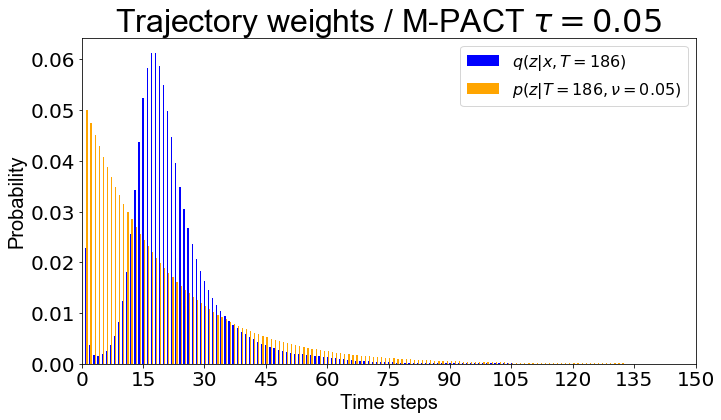

In [19]:
exper = new_experiments[2]
x_max = 150
hyper_param = str.replace(str(1-exper.config.ptT_shape_param), '.', '_')
plot_actsb_qts(exper, data_set="eval", save=True, show=True, add_info=False, epoch=400, plot_prior=True,
              fig_name="trajectory_weights_test" + "_t{}".format(hyper_param), 
              huge=True,
              p_title=r"Trajectory weights / M-PACT $\tau={}$".format(1-exper.config.ptT_shape_param),
              height=6, width=11, x_max=x_max)

In [ ]:
plot_dist_optimization_steps(new_experiments[2], data_set="eval", save=True, show=True, epoch=400, 
                            huge=True, xlimits=None, plot_title="Halting step histogram",
                            fig_name="test10000_halt_histogram")

INFO - Successfully saved fig logs/run_20171003_22_05_48_act_sbV3.2_50ep_nu0.95kls1.0_lr5e05/input_dependency_t0_05.png


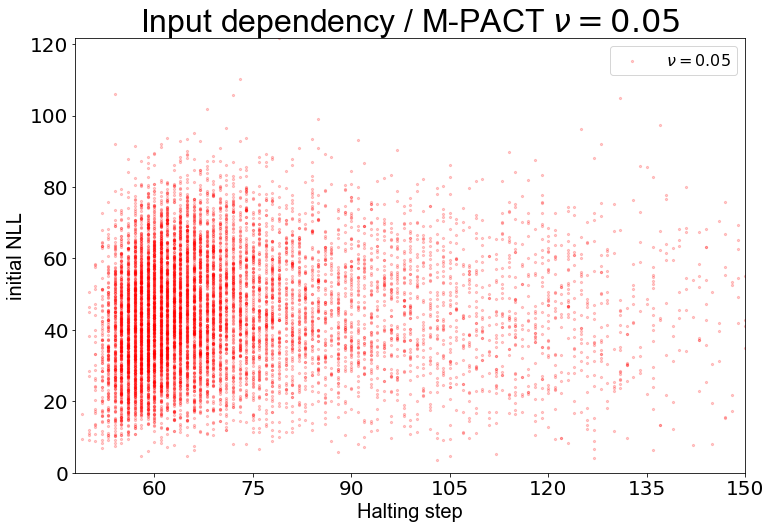

Mean 72.2375, Std 19.6229889097, Median 65, Total steps 722375


In [22]:
exper = new_experiments[2]
x_max = 150
hyper_param = str.replace(str(1-exper.config.ptT_shape_param), '.', '_')
plot_loss_versus_halting_step(exper, epoch=400, do_show=True, do_save=True, x_max=x_max,
                              p_title="Input dependency / M-PACT" + r" $\nu={}$".format(1-exper.config.ptT_shape_param), 
                              huge=True, log_scale=False,
                              fig_name="input_dependency" + "_t{}".format(hyper_param))

[ 20  40  60  80 100]
INFO - Successfully saved fig logs/run_20171003_21_29_12_act_sbV3.2_50ep_nu0.5kls1.0_lr5e05/10dregT_mpact_st_losses_t0_5.png


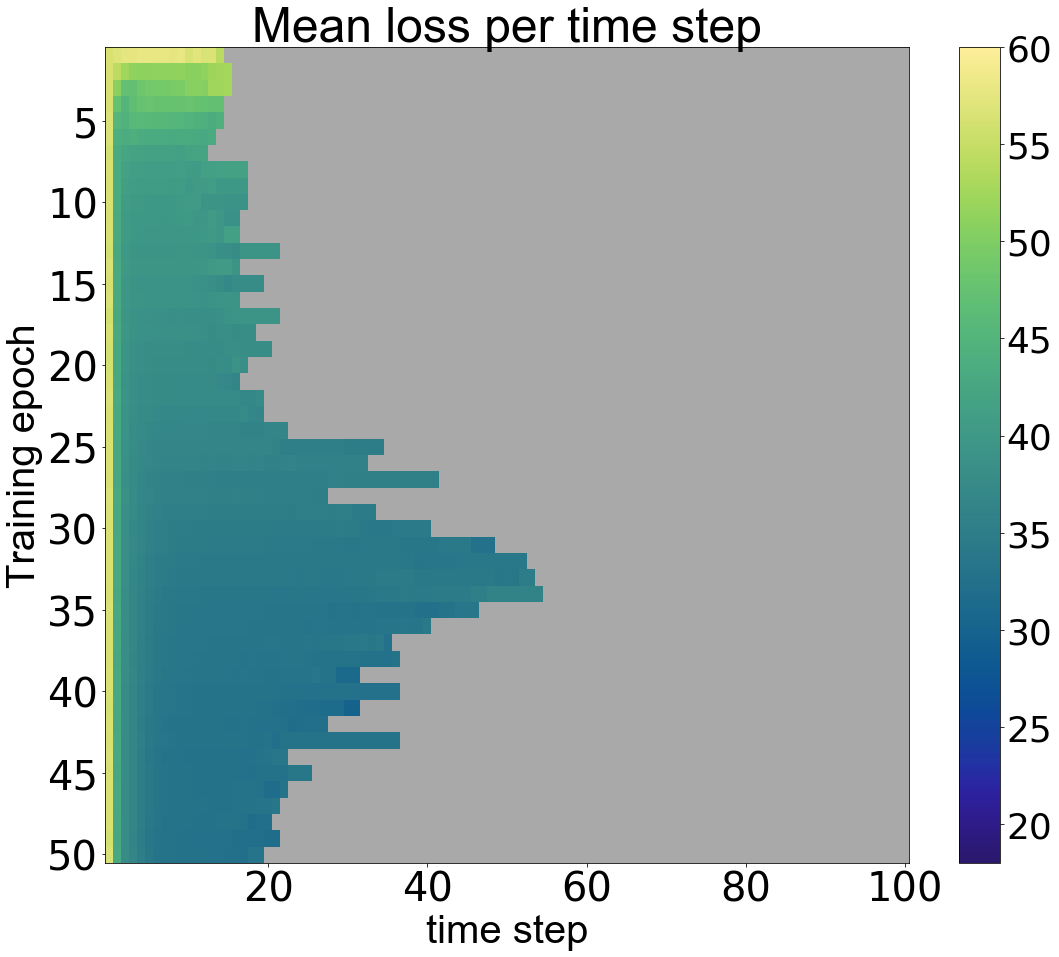

In [6]:
exper = experiments[0]
max_epoch = None
hyper_param = str.replace(str(exper.config.ptT_shape_param), '.', '_')
plot_image_map_losses(exper, fig_name="10dregT_mpact_st_losses" + "_t{}".format(hyper_param),
                      do_save=True, do_show=True, 
                      max_epoch=max_epoch, max_time_step=None, 
                      fig_title="Mean loss per time step", 
                      scale= [18,60], huge=True)

[ 20  40  60  80 100]
INFO - Successfully saved fig logs/run_20171003_21_29_12_act_sbV3.2_50ep_nu0.5kls1.0_lr5e05/10dregT_mpact_train_halt_dist_t0_5.png


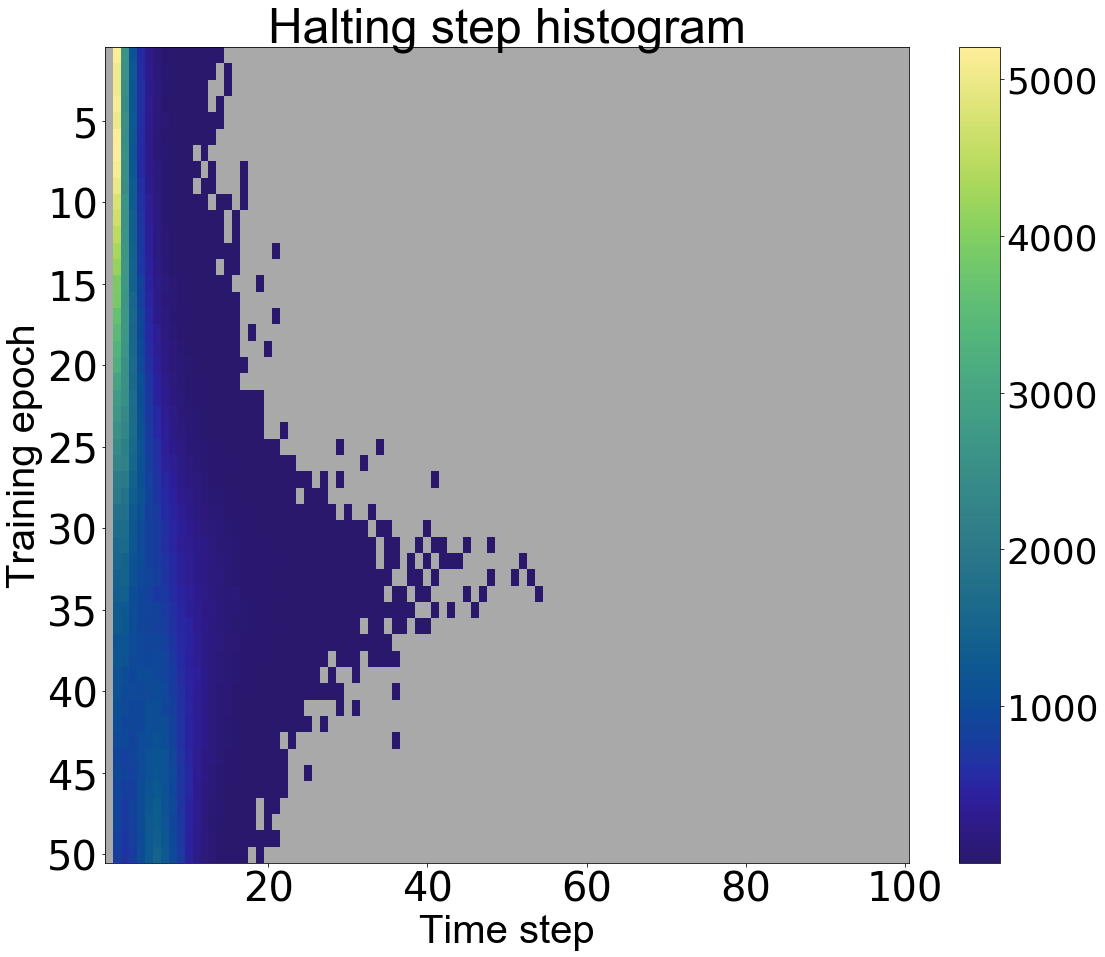

In [7]:
idx = 0

exper = experiments[idx]
if "act_sbV3.2" in exper.args.model:
    p_title="Halting step histogram"
    hyper_param = str.replace(str(exper.config.ptT_shape_param), '.', '_')
    fig_name="10dregT_mpact_train_halt_dist" + "_t{}".format(hyper_param)
else:
    p_title="Halting step histogram"
    hyper_param = str.replace(str(exper.config.tau), '.', '_')
    fig_name="10dregT_mact_train_halt_dist" + "_t{}".format(hyper_param)
    
max_epoch = None

plot_image_map_data(exper, data_set="train",  do_save=True, do_show=True,
                        data="halting_step",  
                        max_epoch=max_epoch, max_time_step=100,
                        huge=True, 
                        plot_title=p_title,
                        fig_name=fig_name)

In [ ]:
expers_to_load = [# M-ACT V1 model regression
                  (True, "run_20170925_11_55_49_metaV1_65ep_50ops_lr4e05"),
                  (True, "run_20170929_11_08_20_metaV1_40ep_100ops_lr4e05"),
                  (True, "run_20171001_19_08_49_meta_actV1_40ep_tau0.004_lr4e05"),
                  (False, "run_20171001_18_06_58_meta_actV1_40ep_tau0.005_lr4e05"),
                  ]

In [ ]:
test_funcs = RegressionFunction(n_funcs=10000, n_samples=10, stddev=1., x_dim=10, use_cuda=True, 
                                calc_true_params=False)
with open("data/test_regression_10000_10_1.0_10.dll", 'wb') as f:
     dill.dump(test_funcs, f)
print("Ready")

In [17]:

total_ops = 0
idx = 2
exper = experiments[idx]
new_exper = new_experiments[idx]
print(exper.args.model)
if "act_sbV3.2" in exper.args.model:
    total_ops = compute_total_steps(exper, epoch_range=None)
step_losses = get_evaluation_step_loss(new_exper, steps=[1, 10, 50, 100])
print("Total steps {}".format(total_ops))
print("Step losses")
print(np.array_str(step_losses, precision=2))

metaV1_regression_T_20ops
Total steps 0
Step losses
[ 51.86  30.88  23.25  21.47  20.07]


In [7]:
# USED THIS SECTION ONLY FOR CALCULATING THE LOSS AT STEP E[T]
total_ops = 0
idx = 1
new_exper = new_experiments[idx]
print(new_exper.args.model)

step_losses = get_evaluation_step_loss(new_exper, steps=[1, 10, 12, 13, 50, 100])
print("Total steps {}".format(total_ops))
print("Step losses")
print(np.array_str(step_losses, precision=5))

act_sbV3.2_regression_T_nu0.5
Total steps 0
Step losses
[ 42.58028  29.03479  28.02287  27.63039  22.3526   20.49414  19.15871]


In [12]:

idx = 5
new_exper = new_experiments[idx]
print(new_exper.args.model)
mean, std, median, _ , a_range = new_exper.get_step_dist_statistics(with_range=True)
print("[{}, {}] & {:.2f} & {:.2f} & {} ".format(a_range[0], a_range[1], round(mean,2), round(std,2), median))

act_sbV3.2_regression_T_nu0.5
[10, 19] & 12.71 & 0.99 & 13 


In [ ]:
experiments[0].generate_figures()

In [5]:
test_funcs = RegressionWithStudentT(n_funcs=20, n_samples=10, x_dim=10, scale_p=1., shape_p=1, use_cuda=True)

INFO - Successfully saved fig figures/regT_mpact_mean_halt_all.png


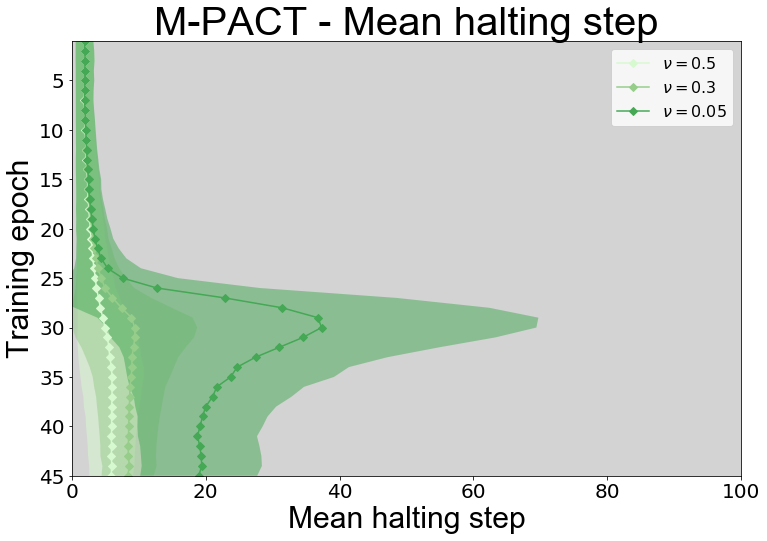

In [6]:
from utils.plots import plot_halting_step_stats

    
plot_halting_step_stats(experiments, do_show=True, do_save=True, last_epoch=[45, 45, 45],
                        fig_title="M-PACT - Mean halting step", fig_name="regT_mpact_mean_halt_all")

In [22]:
from utils.common import compute_mean_training_horizon
print(compute_mean_training_horizon(experiments[1]))

3.847312


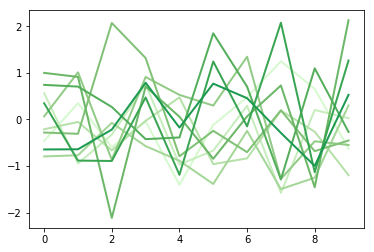

In [27]:
import palettable
from cycler import cycler
ax = plt.figure().gca()
ax.set_prop_cycle(cycler('color',palettable.cmocean.sequential.Algae_20.mpl_colors))
plt.plot(np.random.randn(10,10),linewidth=2);

INFO - Successfully saved fig logs/run_20171003_22_05_48_act_sbV3.2_50ep_nu0.95kls1.0_lr5e05/qzx_marginal_nu0_05.png


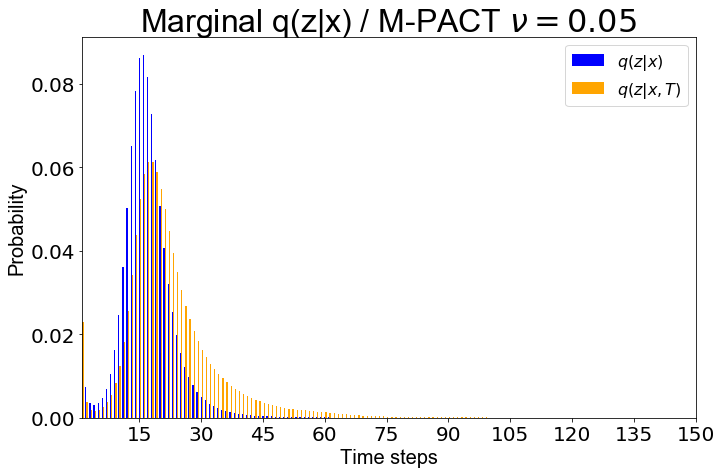

In [14]:
idx = 2

q_z = new_experiments[idx].val_stats["qzx_dist"]

max_time_step = 150
p_title = r"Marginal q(z|x) / M-PACT $\nu={}$".format(1 - new_experiments[idx].config.ptT_shape_param)
# q_z = compute_marginal_q_z(qTx_dict, qzxT_dict, max_t)
# q_z = new_experiments[idx].val_stats["qzx_dist"]
# print(q_z)
plot_marginal_qz(new_experiments[idx], q_z, huge=True, p_title=p_title, do_save=True, plot_conditional=True,
                 max_time_step=max_time_step)

In [7]:


idx = 0
qzxT = new_experiments[idx].val_stats["qzxT"]

In [8]:
qzxT.shape

(10000, 200)

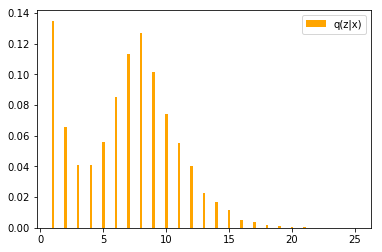

[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
INFO - Successfully saved fig logs/run_20171003_21_29_12_act_sbV3.2_50ep_nu0.5kls1.0_lr5e05/qzxT_conditionals0_5.png


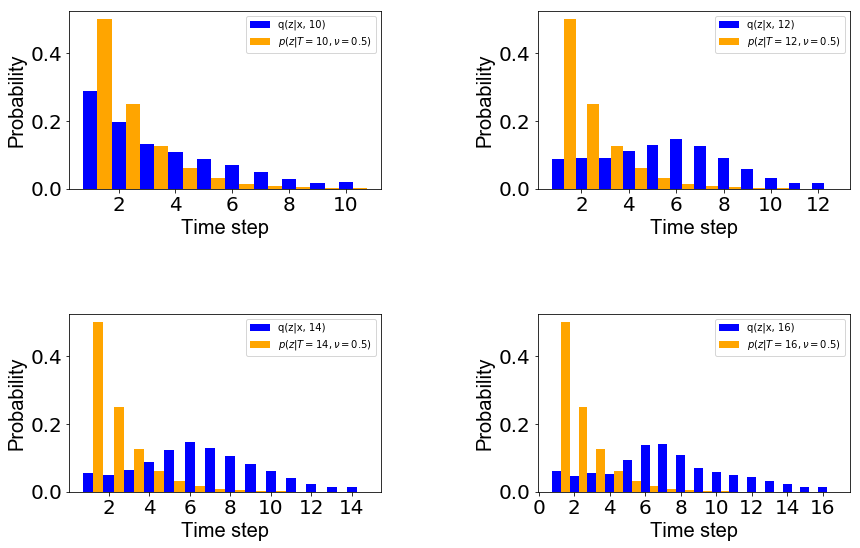

In [7]:
from utils.common import compute_mean_qTx_qzxT
from pylab import MaxNLocator
from scipy.stats import geom
from utils.plots import plot_qtT_distributions


idx = 0

np_rhos = new_experiments[idx].val_stats["rhos"]
halt_steps = new_experiments[idx].val_stats["halting_step"][400]
_, qt_H, qzT_H = compute_mean_qTx_qzxT(np_rhos, halt_steps)
print(qzT_H.keys())

filter_horizons = [10, 12, 14, 16]

plot_qtT_distributions(new_experiments[idx], qzT_H, do_save=True, plot_prior=True, height=20,
                       filter_horizons=filter_horizons)